In [1]:
import base64
import io
import os

from bertopic import BERTopic
from bertopic.representation import VisualRepresentation
import dotenv
import numpy as np
import pandas as pd
import tqdm

from topic_model_videos import get_video_path, save_first_frame

/home/bsteel/miniconda3/envs/whatforwhere/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dotenv.load_dotenv()
bytes_dir_path = os.path.join(os.environ['DATA_DIR_PATH'], 'bytes')

In [3]:
def get_videos_embeddings(bytes_dir_path, limit=None):
    embeddings = None
    video_df = None
    dirs = os.listdir(bytes_dir_path)
    if limit is not None:
        dirs = dirs[:limit]
    for dir_name in tqdm.tqdm(dirs):
        filenames = os.listdir(os.path.join(bytes_dir_path, dir_name))
        if 'video_embeddings.npy' in filenames and 'videos.parquet.gzip' in filenames:
            batch_embeddings = np.load(os.path.join(bytes_dir_path, dir_name, 'video_embeddings.npy'), allow_pickle=True)
            if not batch_embeddings.shape:
                continue

            batch_video_df = pd.read_parquet(os.path.join(bytes_dir_path, dir_name, 'videos.parquet.gzip'))

            if batch_embeddings.shape[0] != batch_video_df.shape[0]:
                continue

            batch_video_df['video_path'] = batch_video_df['video'].map(get_video_path)
            indexer = batch_video_df['video_path'].apply(lambda p: os.path.exists(p))
            if indexer.sum() == 0:
                continue
            batch_embeddings = batch_embeddings[indexer]
            batch_video_df = batch_video_df[indexer]
            batch_video_df['image'] = batch_video_df['video_path'].map(save_first_frame)

            assert batch_embeddings.shape[0] == len(batch_video_df)

            if embeddings is None:
                embeddings = batch_embeddings
            else:
                embeddings = np.concatenate([embeddings, batch_embeddings])

            if video_df is None:
                video_df = batch_video_df
            else:
                video_df = pd.concat([video_df, batch_video_df])

    return embeddings, video_df

In [4]:
embeddings, video_df = get_videos_embeddings(bytes_dir_path, limit=100)

100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


In [11]:
# Additional ways of representing a topic
visual_model = VisualRepresentation()

# Make sure to add the `visual_model` to a dictionary
representation_model = {
    "Visual_Aspect":  visual_model,
}

# Train our model with images only
topic_model = BERTopic(representation_model=representation_model, verbose=True)
docs = video_df['video'].map(lambda v: v['desc']).tolist()
topics, probs = topic_model.fit_transform(
    documents=docs, 
    embeddings=embeddings,
    images=video_df['image'].tolist()
)

2024-06-21 17:58:39,187 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-21 17:59:09,523 - BERTopic - Dimensionality - Completed ✓
2024-06-21 17:59:09,524 - BERTopic - Cluster - Start clustering the reduced embeddings
480.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
480.26s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
480.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
480.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2024-06-21 17:59:17,229 - BERTopic - Cluster - Completed ✓
2024-06-21 17:59:17,240 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 177/177 [00:23<00:00,  7.46it/s]
2024-06-21 17:59:41,908 - BERTopic - Representation - Completed ✓


In [15]:
fig_dir_path = os.path.join("..", "figs")
data_dir_path = os.path.join("..", "data")
video_df['topic'] = topics
video_df.to_parquet(os.path.join(data_dir_path, 'video_topics.parquet.gzip'))

topic_info_df = topic_model.get_topic_info()

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with io.BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()


def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

topic_info_path = os.path.join(fig_dir_path, 'topic_info.html')
topic_info_df.to_html(topic_info_path, formatters={'Visual_Aspect': image_formatter}, escape=False)
topic_info_df[['Topic', 'Count', 'Name', 'Representation', 'Representative_Docs']].to_parquet(os.path.join(data_dir_path, 'topic_info.parquet.gzip'))

In [14]:
from umap import UMAP
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

SystemError: CPUDispatcher(<function nn_descent at 0x7f7012f72dd0>) returned a result with an exception set

In [16]:
np.save(os.path.join(data_dir_path, 'reduced_embeddings.npy'), reduced_embeddings)

KeyboardInterrupt: 

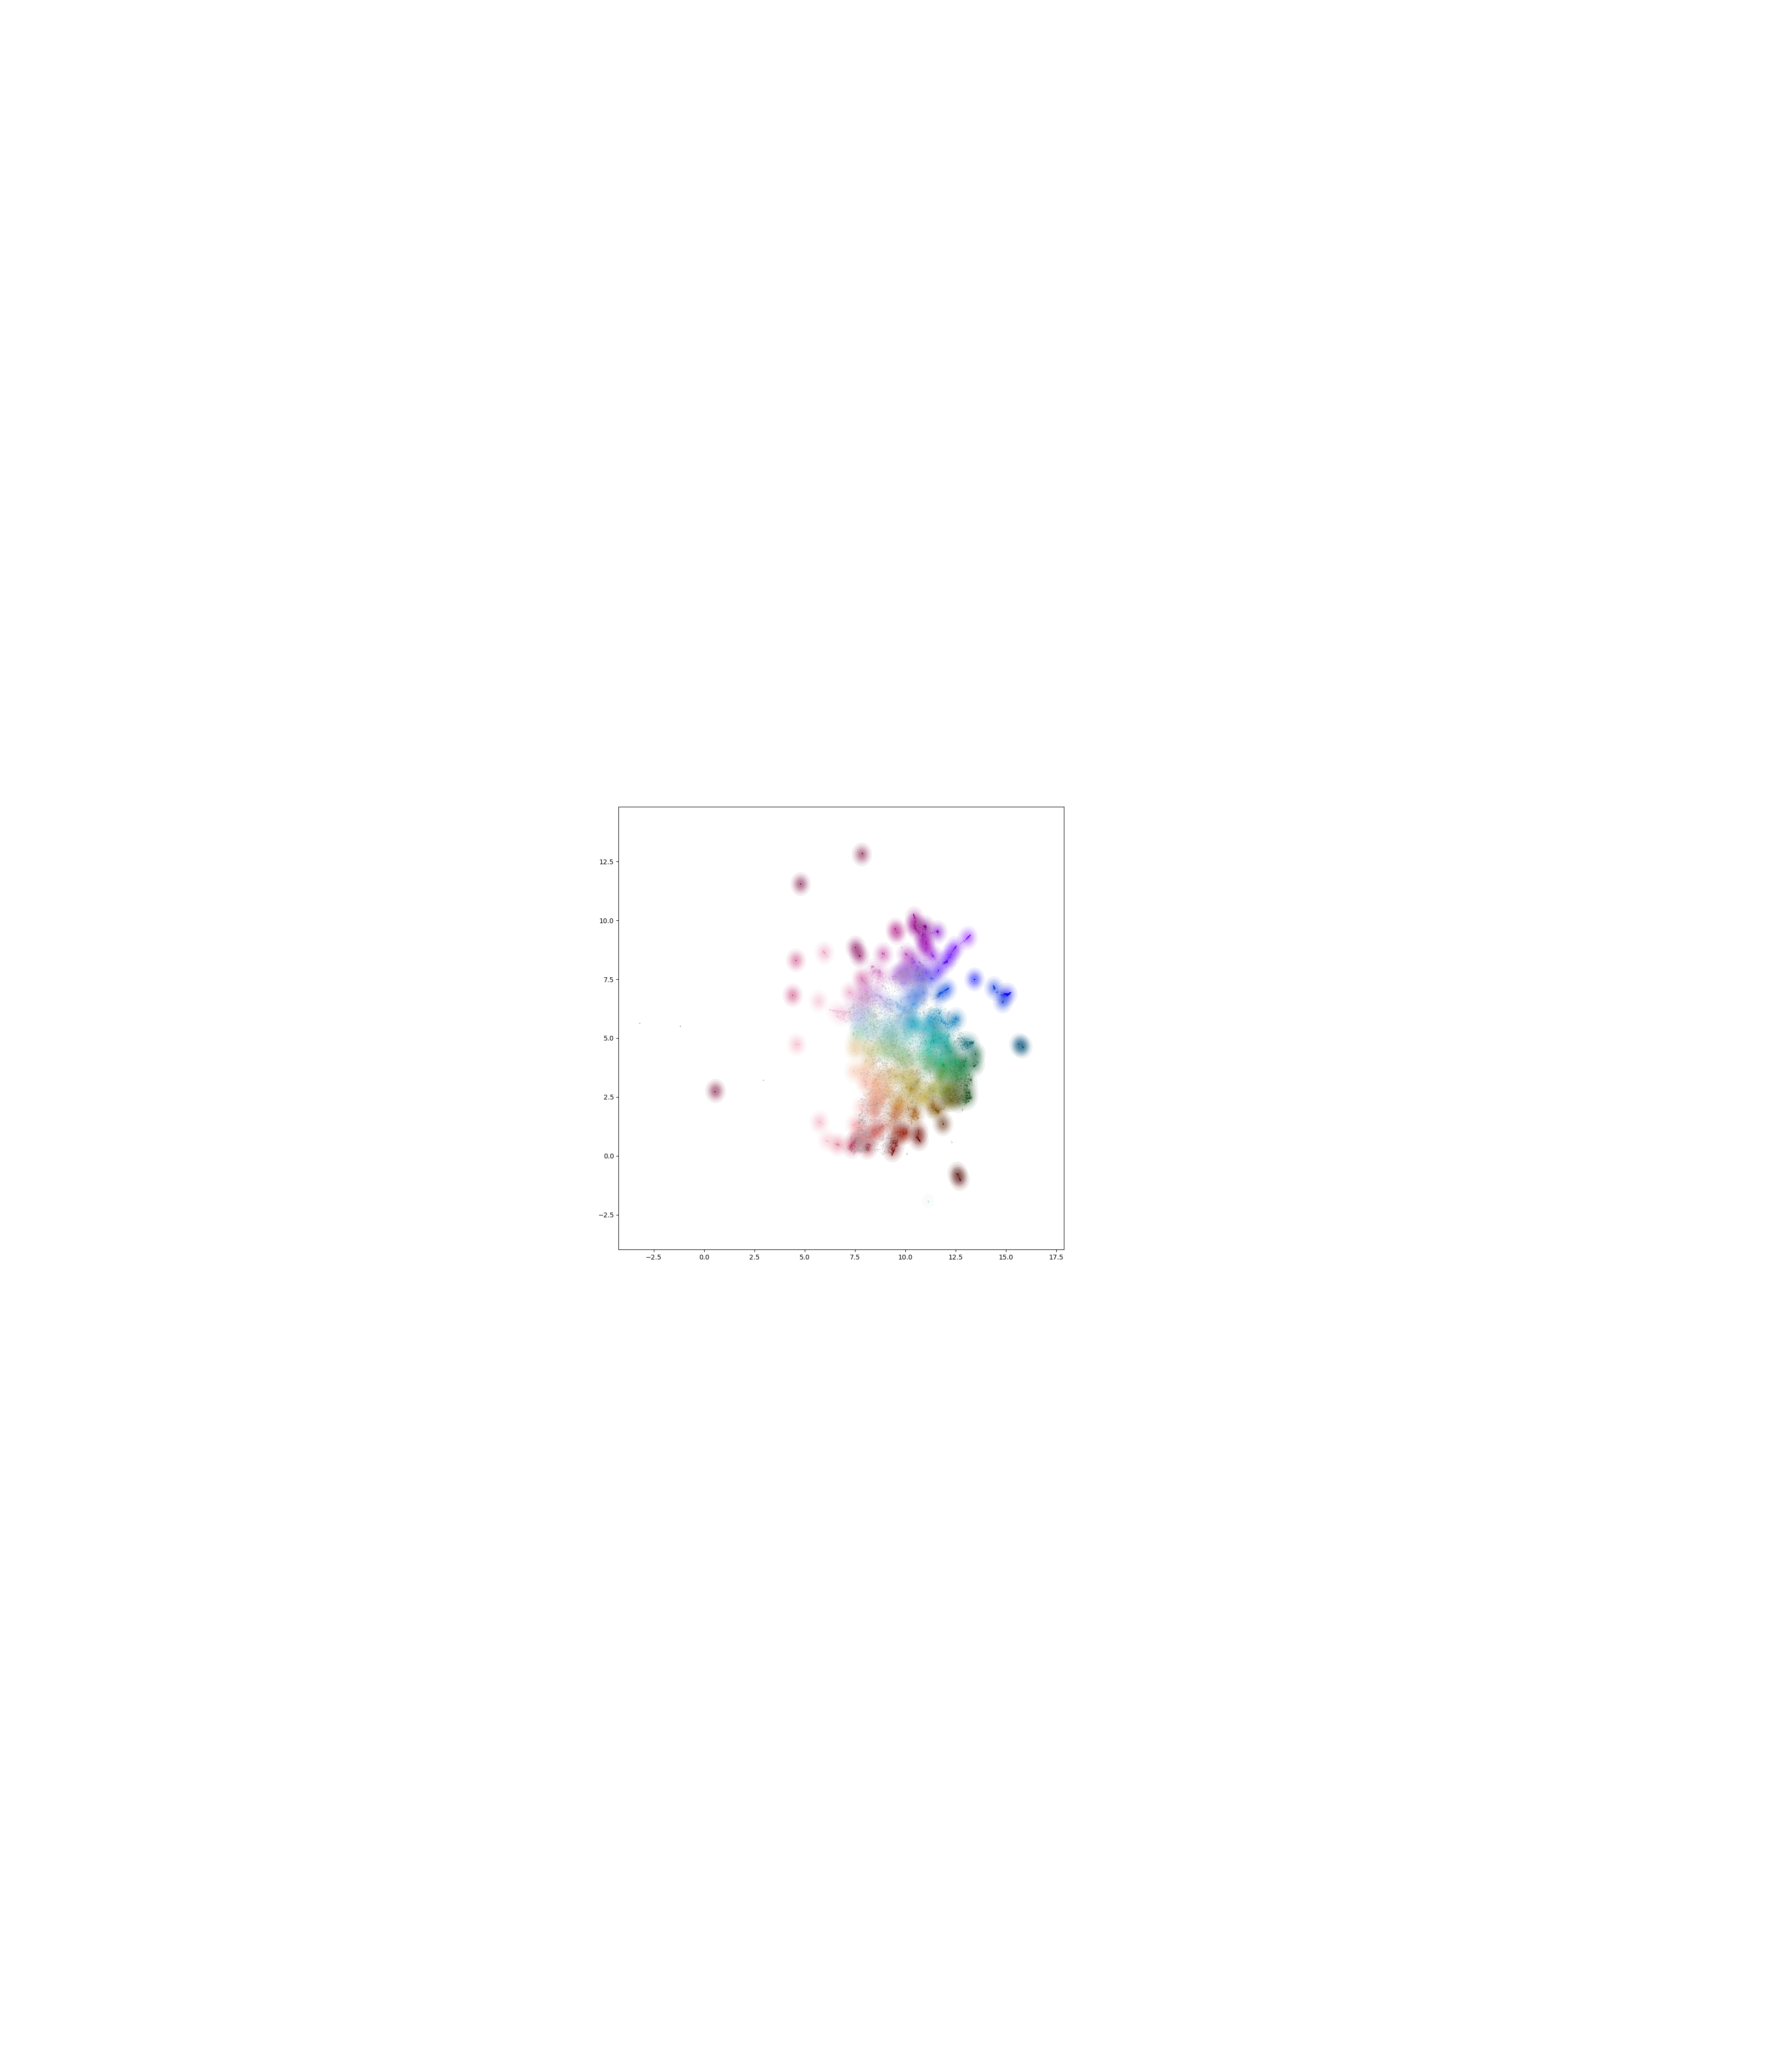

In [13]:
topic_model.visualize_document_datamap(docs, reduced_embeddings=reduced_embeddings)